<a href="https://colab.research.google.com/github/wakasu/Dog-Breed-Classifier/blob/master/Dog_Breed_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries for notebook
!pip install tensorflow==2.0
from sklearn.datasets import load_files       
import numpy as np
from glob import glob
from tqdm import tqdm

import cv2, os
from PIL import ImageFile
import matplotlib.pyplot as plt                        
%matplotlib inline 
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions 
from tensorflow.keras.preprocessing import image                  

print(tf.__version__)
print(keras.__version__)

2.0.0
2.2.4-tf


In [2]:
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip
!unzip lfw.zip
!unzip dogImages.zip

--2019-11-18 00:41:38--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.33
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  57.3MB/s    in 18s     

2019-11-18 00:41:56 (59.9 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

--2019-11-18 00:41:57--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.120
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196739509 (188M) [application/zip]
Saving to: ‘lfw.zip’

lfw.zip             100%[================

In [3]:
def load_dataset(path):
  data = load_files(path)
  dog_files = np.array(data['filenames'])
  dog_targets = tf.keras.utils.to_categorical(np.array(data['target']), 133)
  return dog_files, dog_targets

train_files, train_targets = load_dataset('/content/dogImages/train')
valid_files, valid_targets = load_dataset('/content/dogImages/valid')
test_files, test_targets = load_dataset('/content/dogImages/test')

# Load list of dog names
dog_names = [item for item in sorted(glob("/content/dogImages/train/*/"))]

# Print statistics about datasets
print('There are %d total dog categories.' % len(dog_names))
print("There are %d total dog images.\n" %len(np.hstack([train_files, valid_files, test_files])))
print("There are %d training dog images." % len(train_files))
print("There are %d validation dog images." %len(valid_files))
print("There are %d test dog images." % len (test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [4]:
# Analysis of the number of images per class
globlist = list(glob("/content/dogImages/train/*/"))

# Extract number of images per class
img_per_class = []
for folder in globlist:
  class_length = (len(folder))
  img_per_class.append(class_length)
print(img_per_class)

# Average number of images per class
print("mean:", np.mean(img_per_class))
print("max:", np.max(img_per_class))
print("min:", np.min(img_per_class))

[52, 42, 39, 49, 54, 48, 52, 45, 60, 42, 47, 56, 59, 48, 64, 45, 46, 50, 51, 43, 46, 38, 49, 43, 44, 39, 49, 46, 48, 46, 52, 50, 47, 42, 43, 37, 44, 41, 56, 43, 49, 36, 43, 46, 43, 38, 44, 40, 49, 43, 45, 39, 37, 37, 52, 45, 48, 46, 42, 50, 50, 37, 40, 36, 49, 44, 45, 39, 43, 47, 37, 51, 47, 48, 52, 51, 38, 42, 40, 52, 46, 44, 37, 39, 56, 48, 44, 38, 44, 51, 58, 43, 40, 38, 44, 36, 48, 45, 54, 35, 40, 55, 48, 40, 47, 36, 45, 43, 53, 35, 46, 50, 54, 48, 50, 39, 45, 43, 36, 42, 39, 35, 42, 46, 49, 40, 48, 40, 44, 46, 36, 57, 52]
mean: 45.203007518796994
max: 64
min: 35


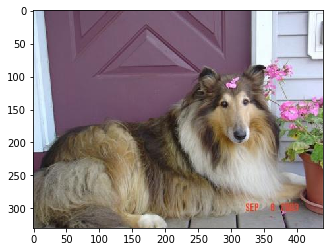

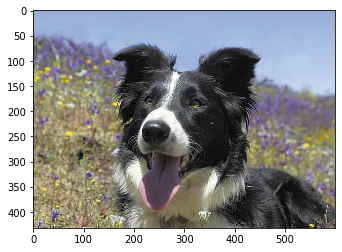

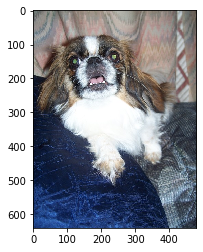

In [5]:
# Function to displyaing images in training set

def random_image(x):
  '''
  function shows images in traing set
  INPUT: integer between 0 and 6680
  Output: image
  '''
  img = cv2.imread(train_files[x])
  cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(cv_rgb)
  plt.show()
random_image(6)
random_image(433)
random_image(5555)

In [6]:
import random
random.seed(8675309)

# Load fiels in shuffled human dataset
human_files = np.array(glob("/content/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print("There are %d total human images." % len(human_files))

There are 13233 total human images.


Number of faces detected: 1


<function matplotlib.pyplot.show>

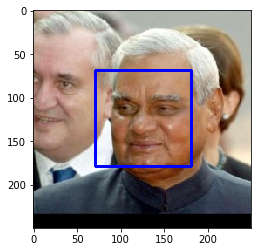

In [7]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_alt.xml")

# load color (BRG) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#find faces in the image
faces = face_cascade.detectMultiScale(gray)
print("Number of faces detected:", len(faces))

# get bounding box for each detected face
for(x,y,w,h) in faces:
  # add bounding box to color image
  cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

#convert the BGR image to RGB for plotting

cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image along with the bounding box
plt.imshow(cv_rgb)
plt.show

In [0]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [9]:
# Detecting Human faces in human files and dog files to chek
# the accuracy of our face detector code

human_files_short = human_files[:100]
dog_files_short = train_files[:100]

count = len([i for i in human_files_short if face_detector(i) == True])
print("Number of humans correctly identified as humas: ", count)

count = len([i for i in dog_files_short if face_detector(i) == True])
print("Number of dogs identified as humans", count)

Number of humans correctly identified as humas:  99
Number of dogs identified as humans 12


In [10]:
ResNet50_model = ResNet50(weights='imagenet')

102973440/102967424 [==============================] - 2s 0us/step


In [0]:
# Function that process images before sending to CNN
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
  list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
  return np.vstack(list_of_tensors)

In [0]:
def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [0]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

In [15]:
count = len([img for img in human_files_short if dog_detector(img) == True])
print("Number of humans identified as dogs: ",count)

Number of humans identified as dogs:  1


In [16]:
count = len([img for img in dog_files_short if dog_detector(img) == True])
print("Number of dog images identified as dogs: ",count)

Number of dog images identified as dogs:  100


In [17]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:07<00:00, 114.19it/s]


In [18]:
train_tensors.shape
from tensorflow.keras

(6680, 224, 224, 3)

In [21]:
model = Sequential()
# CNN
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(244,244,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPoolng2D(pool_size=2))
model.add(Cov2D(filters=64, kernel_sizes=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D(input_shape=(28,28,64)))
model.add(Dropout(0.15))

#MLP Frintend
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(133, activation='softmax'))

NameError: ignored

In [0]:
model.summary()

In [0]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [0]:
epochs = 30

checkpointer = ModelCheckpoit(filepath = '/content/weights.best.from_scratch.hdf5',
                              verbose = 1,
                              save_best_only = True)
model.fit(train_tensors, train_targets,
          validation_data=(valid_tensors, valid_targets),
          epochs = epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

In [0]:
model.load_weights('/content/weights.best.from_scratch.hdf5')

In [0]:
# get index for the preicted dog breed for each image in the test set
dog_breed_predictions = [np.argamax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy 
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argamax(test_targets, axis=1)/len(dog_breed_predictions))
print('Test accuracy: %.4f%%' %test_accuracy)

In [0]:
!wget wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG16Data.npz

In [0]:
bottleneck_features = np.load('/content/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [0]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

In [0]:

VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [0]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

In [0]:
VGG16_model.load_weights('/content/weights.best.VGG16.hdf5')

In [0]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

In [0]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [0]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
! wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz

In [0]:
# Obtain bottleneck features for Resnet50
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_resnet50 = bottleneck_features['train']
valid_resnet50 = bottleneck_features['valid']
test_resnet50 = bottleneck_features['test']

In [0]:
# feature extractor shape
train_resnet50.shape

In [0]:
# Define your architecture.
resnet50_model = Sequential()
resnet50_model.add(GlobalAveragePooling2D(input_shape=train_resnet50.shape[1:]))
resnet50_model.add(Dense(1024, activation='relu'))
resnet50_model.add(Dropout(0.4))
resnet50_model.add(Dense(133, activation='softmax'))

resnet50_model.summary()

In [0]:
# Compile the model.
resnet50_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [0]:
# Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.resnet50.hdf5', 
                               verbose=1, save_best_only=True)

resnet50_model.fit(train_resnet50, train_targets, 
          validation_data=(valid_resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

In [0]:
# Load the model weights with the best validation loss.
resnet50_model.load_weights('/content/weights.best.resnet50.hdf5')

In [0]:
resnet50_model.summary()

In [0]:
# Save full model for web app
resnet50_model.save('my_model.h5')

In [0]:
from keras.models import load_model
model = load_model('my_model.h5')
model.summary()

In [0]:
# Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
resnet50_predictions = [np.argmax(resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(resnet50_predictions)==np.argmax(test_targets, axis=1))/len(resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

In [0]:
### Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *

def resnet50_predict_breed(img_path):
    """
    INPUT: path to an image
    OUTPUT: returns a prediction of dog breed
    """
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    
    # obtain predicted vector
    predicted_vector = resnet50_model.predict(bottleneck_feature)
    
    # get class with highest probability and match to label for class
    predicted_index = np.argmax(predicted_vector)
    label = dog_names[predicted_index]
    
    return label #predicted_index

In [0]:
def predictor(img_path):
    """
    This function takes in an image and returns a prediction on dog breed.
    INPUT: the path to the image to be classified
    OUTPUT: returns either dog breed, human dog breed or neither dog or human
    """
    # check if image is a dog
    dog = dog_detector(img_path)
    
    # check if image contains a human face
    human = face_detector(img_path)
    
    # make a prediction of dog_breed based on image
    dog_breed = resnet50_predict_breed(img_path)
    
    # plot image with comment
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    
    if dog:
        return("This photo looks like a {}".format(dog_breed))
    elif human:
        return("This human resembles a {}".format(dog_breed))
    else:
        return("This is neither dog beast or human!")

In [0]:
image_list = glob("images/*test.jpg")
image_list

In [0]:
predictor(image_list[0])
predictor(image_list[1])
predictor(image_list[2])
predictor(image_list[3])
predictor(image_list[4])
predictor(image_list[5])